In [1]:
import gym
import time
import random
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [2]:
env = gym.make("Taxi-v3",render_mode="ansi")

In [5]:
# implementation of epsilon greedy action selection (multi-armed bandit)
def epsilon_greedy_agent(epsilon,state,QTable):
    x = bernoulli.rvs(1-epsilon, size=1)
    if x == 1:
        # exploit: select best performing action w/ probability 1 - epsilon
        action = np.argmax(QTable[state])
    else:
        # explore: randomly select action for exploration w/ probability epsilon
        action = env.action_space.sample()
    return action

def TD_error(reward,gamma,QTable,next_state,state,action):
    delT = reward + gamma * np.max(QTable[next_state]) - QTable[state,action]
    return delT

# From Sutton and Barto (2018), p. 131
def train_Qlearning(alpha,epsilon,gamma,episodes,maxSteps,verbose=False):
    print("Begin training...")
    # initialize Q-table
    QTable = np.zeros([env.observation_space.n,env.action_space.n])
    stepsPerEp = []
    for ep in range(episodes):
        if verbose and ep % 1000 == 0:
            print("Episode %d" % ep)
        # initialize state
        state = env.reset()[0]
        isDone = False
        numSteps = 0
        for t in range(maxSteps):
            # sample action from Q
            action = epsilon_greedy_agent(epsilon,state,QTable)
            # take action, observe reward and next state
            next_state,reward,isDone,_,_ = env.step(action)
            # update Q and state
            delT = TD_error(reward,gamma,QTable,next_state,state,action)
            QTable[state,action] += alpha * delT
            state = next_state
            # until state is terminal
            if isDone == True:
                break
            numSteps += 1
        stepsPerEp.append(numSteps)
    return QTable,stepsPerEp    

# Watkin's-Q(lambda)
def train_QlearningLam(alpha,epsilon,gamma,lam,epsidoes,maxSteps,verbose=False):
    print("Begin training...")
     # initialize Q-table
    QTable = np.zeros([env.observation_space.n,env.action_space.n])
    stepsPerEp = []
    for ep in range(episodes):
        # initialize eligibility traces
        E = np.zeros([env.observation_space.n,env.action_space.n])
        if verbose and ep % 1000 == 0:
            print("Episode %d" % ep)
        # initialize state and action
        state = env.reset()[0]
        action = env.action_space.sample()
        isDone = False
        numSteps = 0
        for t in range(maxSteps):
            # take action a, observe reward and next state (s')
            next_state,reward,isDone,_,_ = env.step(action)
            # choose a' from s' using policy Q
            next_action = epsilon_greedy_agent(epsilon,next_state,QTable)
            # select a*
            opt_action = np.argmax(QTable[next_state])
            # compute TD error
            delT = TD_error(reward,gamma,QTable,next_state,state,action)
            E[state,action] += 1.0
            # for all states and actions
            QTable[:] += alpha * delT * E[:]
            # backup eligibility trace for greedy actions
            if opt_action == next_action:
                E[:] = gamma * lam * E[:]
            # zero out trace after non-greedy/exploratory action
            else:
                E[:] = 0.0
            state = next_state
            action = next_action
            # continue until terminal state
            if isDone:
                break
            numSteps += 1
        stepsPerEp.append(numSteps)
    return QTable,stepsPerEp

### Training

In [6]:
episodes = 10000
maxSteps = 10000
alpha = 0.1
epsilon = 0.1
gamma = 0.1
lam = 0.1
QTable,stepsPerEp = train_QlearningLam(alpha,epsilon,gamma,lam,episodes,maxSteps,verbose=True)

Begin training...
Episode 0
Episode 1000
Episode 2000
Episode 3000
Episode 4000
Episode 5000
Episode 6000
Episode 7000
Episode 8000
Episode 9000


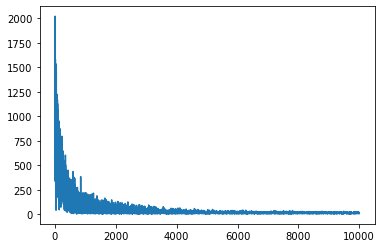

In [7]:
stepsPerEp = np.array(stepsPerEp)
plt.plot(np.arange(episodes)+1,stepsPerEp)

### Testing

In [ ]:
test_env = gym.make("Taxi-v3",render_mode="human")
testEpisodes = 2
epRewards = []
epPenalities = []
epTimesteps = []
verbose = True
for ep in range(testEpisodes):
    if verbose:
        print("Episode %d" % (ep+1))
    start_time = time.time()
    state = test_env.reset()[0]
    test_env.render()
    rewards = []
    isDone = False
    rewards = 0
    timesteps = 0
    penalities = 0
    while not isDone:
        action = np.argmax(QTable[state,:])
        next_state,reward,isDone,_,_ = test_env.step(action)
        state = next_state
        timesteps += 1
        if reward == -10:
            penalities += 1
        rewards += reward
    if verbose:
        print("--- Completed in %s seconds ---" % (time.time() - start_time))
    epRewards.append(rewards)
    epPenalities.append(penalities)
    epTimesteps.append(timesteps)